In [1]:
import glob
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import matplotlib.pyplot as plt
import os.path

In [2]:
# Conveniently list available tracks to analyze
available_track_files = glob.glob("./tracks/**.npy")
available_track_names = list(map(lambda x: os.path.basename(x).split('.npy')[0], available_track_files))
available_track_names

['reInvent2019_track',
 '2022_august_open',
 'Canada_Training',
 'canada_race',
 'Tokyo_Training_track',
 'Oval_track',
 'New_York_Track',
 'Bowtie_track',
 'H_track',
 'reinvent_base',
 '2022_september_open',
 'Mexico_track',
 'Virtual_May19_Train_track',
 'Straight_track',
 'AWS_track',
 'China_track',
 '2022_july_open',
 '2022_june_open',
 'London_Loop_Train']

In [3]:
# Replace the name here with the track to analyze
TRACK_NAME = '2022_september_open'

# Load the center, inner, outer waypoints
waypoints = np.load("./tracks/%s.npy" % TRACK_NAME)

# Separate into center, inner, outer waypoints
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

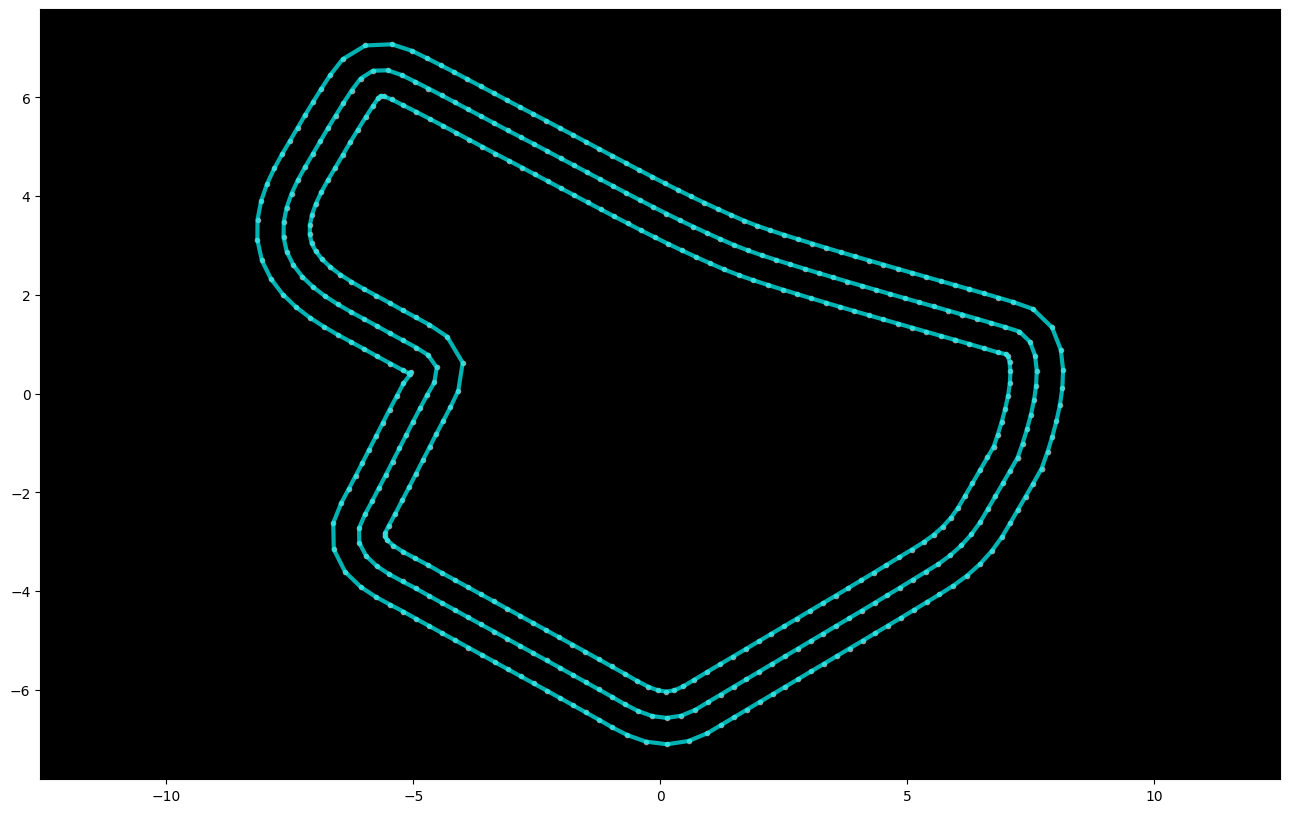

In [4]:
def plot_coords(ax, ob):                                                        
    x, y = ob.xy                                                                
    ax.plot(x, y, '.', color='#999999', zorder=1)                               
                                                                                
def plot_bounds(ax, ob):                                                        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))                          
    ax.plot(x, y, '.', color='#000000', zorder=1)                               
                                                                                
def plot_line(ax, ob):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                                                                                
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)                                                
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)     

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, center_line, inner_border, outer_border)

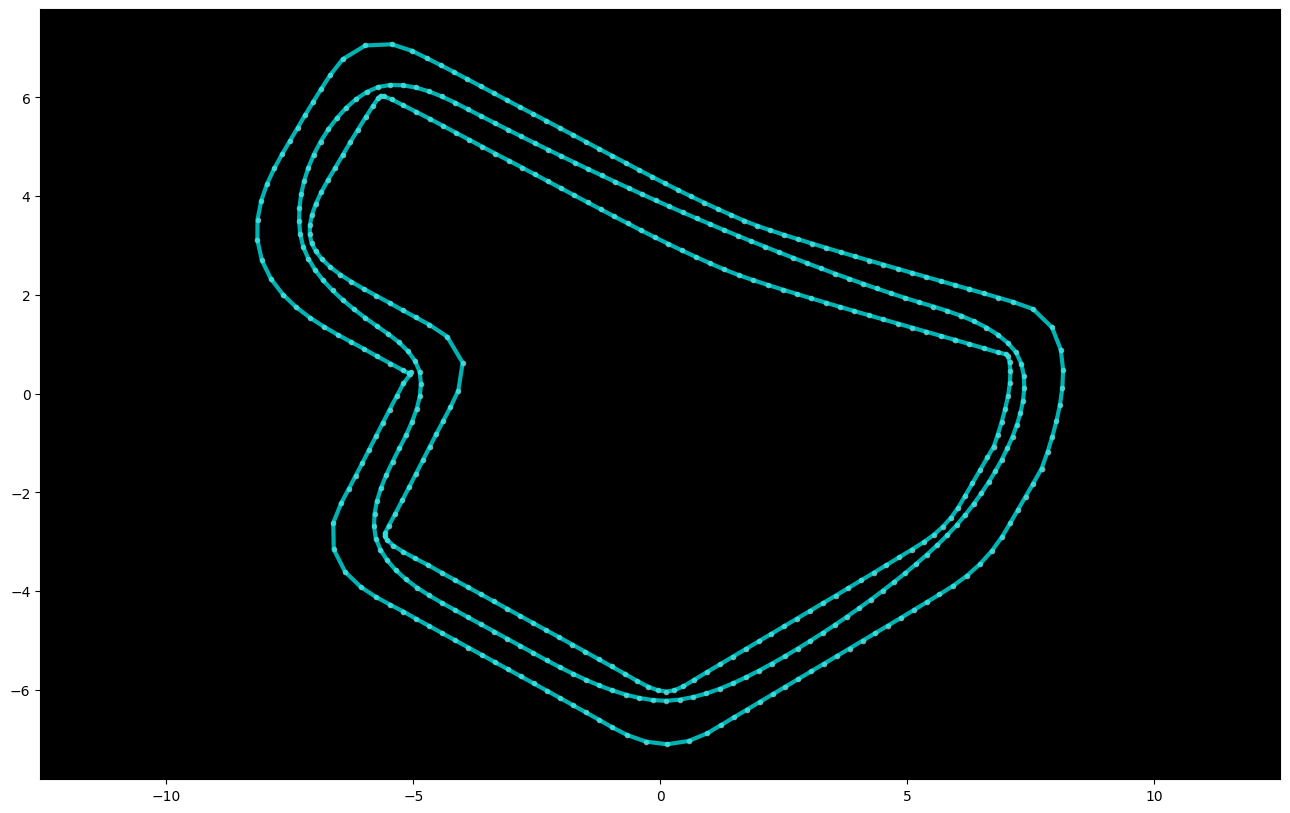

In [5]:
from numpy import array

fname = './racelines/2022_september_open-2000-4-2022-10-23-145109.py'
with open(fname, "r") as file:
    deserialized = eval(file.read())
racing_line = deserialized
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, racing_line, inner_border, outer_border)

In [6]:
def plot_track(ax):
    ax.plot(inner_border[:, 0], inner_border[:, 1], '.', color='#646464', zorder=1)
    ax.plot(outer_border[:, 0], outer_border[:, 1], '.', color='#646464', zorder=1)
    ax.plot(inner_border[:, 0], inner_border[:, 1], color='gray', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    ax.plot(outer_border[:, 0], outer_border[:, 1], color='gray', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

In [7]:
npoints = len(racing_line) - 1

In [8]:
from numpy import array

fname = './track-curvatures/2022_september_open-2022-10-23-150342.py'
with open(fname, "r") as file:
    deserialized = eval(file.read())
track_curvatures = deserialized
len(track_curvatures)

151

In [9]:
MAX_STEERING = 15
MAX_RADIUS = 10
THIRD_POINT_X = 2.25
THIRD_POINT_Y = 6

b = (THIRD_POINT_X * THIRD_POINT_Y * MAX_RADIUS) / (MAX_STEERING * THIRD_POINT_X - MAX_STEERING * MAX_RADIUS + THIRD_POINT_Y * MAX_RADIUS)
a = (MAX_STEERING * b * (b - MAX_RADIUS)) / MAX_RADIUS
c = a/b + MAX_STEERING

optimal_steering = (a / (np.abs(track_curvatures) - b)) + c
optimal_steering *= (track_curvatures / np.abs(track_curvatures))
optimal_steering[np.isclose(optimal_steering, 0)] = 0
optimal_steering

array([  2.03308508,   0.48776709,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.44887921,   2.70687309,   4.43949037,
         5.88211293,   7.02562669,   8.46477259,   9.46626229,
         7.89738353,   6.6968918 ,   5.57660829,   4.32587032,
         4.10423245,   3.92741021,   4.07812725,   4.25936874,
         4.46221765,   4.69016405,   5.08367688,   5.92012086,
         6.80534487,   7.80321827,   6.83741014,   5.80989977,
         4.60159768,   3.56720877,   2.47575954,   1.24

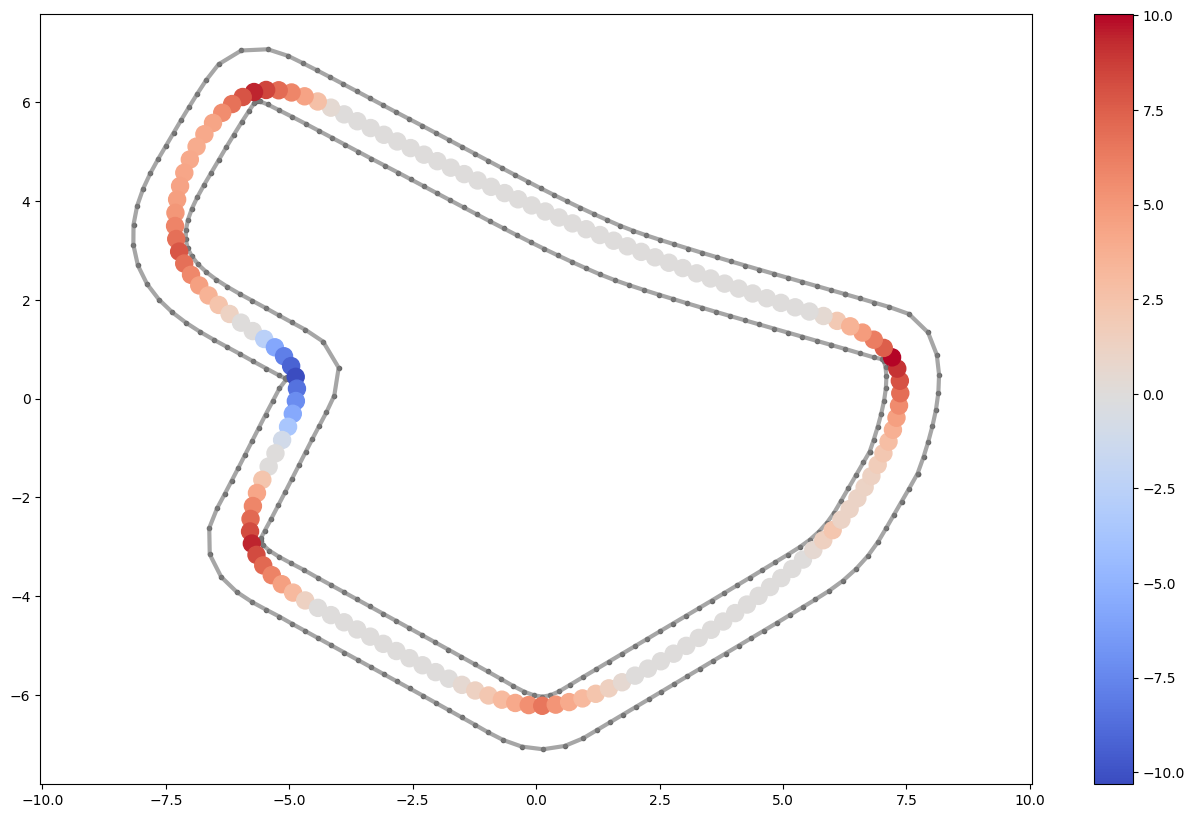

In [10]:
MAX_CURVATURE = 10

fig = plt.figure(2, figsize=(16, 10))
ax = fig.add_subplot(111)
plt.axis('equal')
plot_track(ax)
scatter = ax.scatter(
    racing_line[:npoints, 0], racing_line[:npoints, 1], s=150,
    c=optimal_steering, cmap='coolwarm', zorder=3
)
fig.colorbar(scatter)

In [11]:
from datetime import datetime

now = datetime.now()
prefix = './steering-angles/%s-S%d-R%d-X%.2f-Y%d-%s' % (TRACK_NAME, MAX_STEERING, MAX_RADIUS, THIRD_POINT_X, THIRD_POINT_Y, now.strftime('%Y-%m-%d-%H%M%S'))
py_fname = prefix + '.py'
npy_fname = prefix + '.npy'
with open(py_fname, "w") as file:
    print("Writing python code to %s" % py_fname)
    file.write(np.array_repr(optimal_steering))
    
print("Writing numpy binary to %s" % npy_fname)
np.save(npy_fname, optimal_steering)

Writing python code to ./steering-angles/2022_september_open-S15-R10-X2.25-Y6-2022-10-23-150503.py
Writing numpy binary to ./steering-angles/2022_september_open-S15-R10-X2.25-Y6-2022-10-23-150503.npy
